In [23]:
import matplotlib
matplotlib.use('nbagg')
from scipy import ndimage
import numpy as np
import pickle
import fish_track as ft
import fish_3d as f3
import configparser
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.image import NonUniformImage
from importlib import reload
from scipy import optimize
import itertools
import ipyvolume as ipv
from scipy.spatial.distance import cdist
import yaggie

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
frames = 190
locations = []
for i in range(0, frames):
    pos = np.load(f'location_3d_frame_{i:04}.npy')
    locations.append(pos)

linker = ft.ActiveLinker(20)
trajectories = linker.link(locations)
for dx in np.arange(2, 50, 2):
    trajectories = ft.relink(trajectories, dx, 10)
    
trajectories = [t for t in trajectories if len(t['position']) > 5]

print(len(trajectories))

with open('vanilla_trajectories.pkl', 'wb') as f:
    pickle.dump(trajectories, f)

24 possible links found!
168


In [25]:
ipv.clear()
for t in trajectories:
    signal = np.array(t['position']).T
    adjust = np.array((1.0, 0.5, 0.8))
    ipv.pylab.plot(*signal, color=np.random.random(3) * (1 - adjust / 16) / 2 +  adjust / 2)
ipv.show()

[-288.93966208  246.47342826 -661.92233114] 131.00992989656075


/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


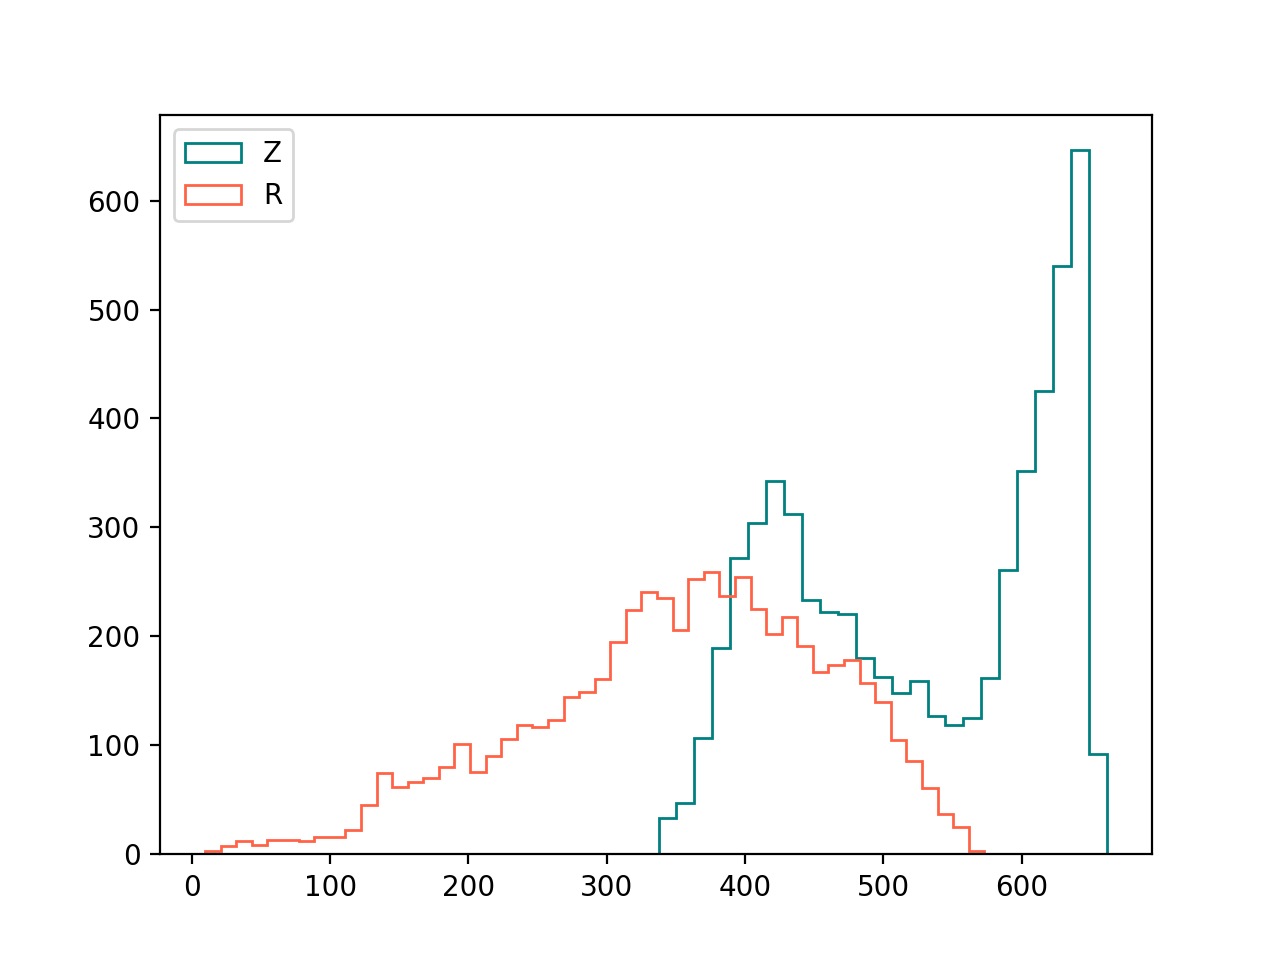

In [178]:
cameras = []
for i in range(1, 4):
    with open(f'result/camera_{i}.pkl', 'rb') as f:
        cameras.append(pickle.load(f))
origins_mv = np.array([[738, 989], [744, 923], [787, 1064]])  # measured manually from FIJI

origin, err = f3.ray_trace.ray_trace_refractive_faster(origins_mv, cameras)
print(origin, err)

frames = 300
locations = np.empty((0, 3))

for t in trajectories:
    pos = t['position']
    locations = np.concatenate([locations, pos])
    
dz = locations[:, -1] - origin[-1]
dr = np.linalg.norm(locations[:, :2] - origin[:2], axis=1)
plt.hist(dz, bins=25, histtype='step', color='teal', label='Z')
plt.hist(dr, bins=50, histtype='step', color='tomato', label='R')
plt.legend()
plt.savefig('spatial_dist.pdf')
plt.show()

<IPython.core.display.Javascript object>


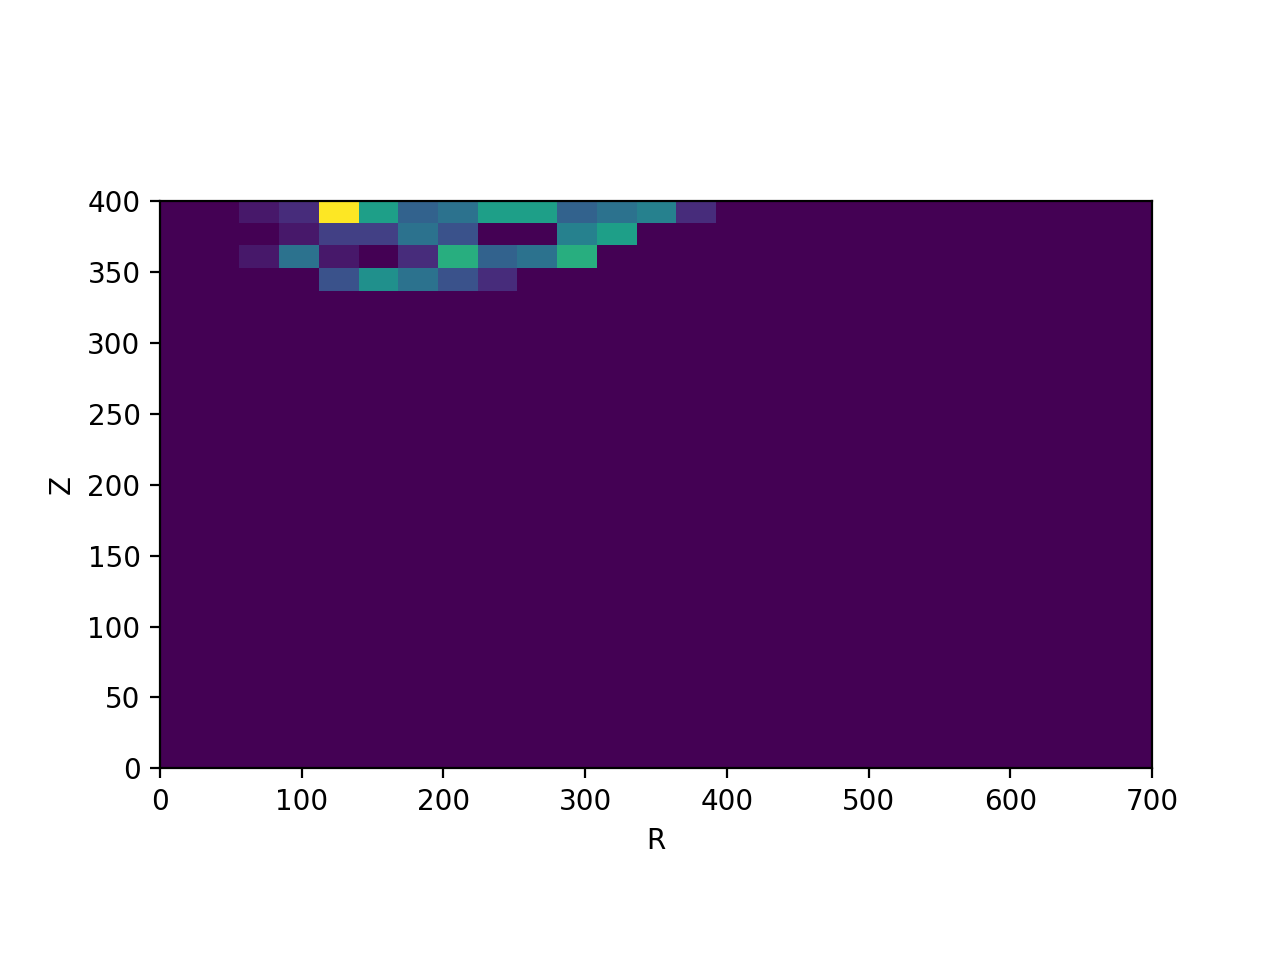

In [55]:
hist_2d, x_edges, y_edges  = np.histogram2d(
    dz, dr, bins=(25, 25), range=((0, 400), (0, 700))
)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', ylim=x_edges[[0, -1]], xlim=y_edges[[0, -1]])

x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
im = NonUniformImage(ax, interpolation='nearest')

im.set_data(y_centers, x_centers, hist_2d)
ax.images.append(im)
ax.set_xlabel('R')
ax.set_ylabel('Z')

plt.savefig('spatial_dist_2d.pdf')

plt.show()